<a href="https://colab.research.google.com/github/CGnal/agos-ai-course/blob/day5/day5/04_Graph_Convolutional_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab\"/></a>

In [1]:
!pip install \
    ipywidgets==7.6.5 \
    networkx==2.4 \
    matplotlib==3.2.2 \
    scikit-learn==0.24.0 \
    pandas==1.1.3 \
    numpy==1.19.2 \
    tensorflow==2.4.1 \
    stellargraph==1.2.1 

# Unsupervised graph representation learning using Graph ConvNet

In this notebook we will be performing unsupervised graph representation learning using Graph ConvNet as encoder.

The model embeds a graph by using stacked Graph ConvNet layers

In [2]:
#from networkx import karate_club_graph, to_numpy_matrix
import numpy as np
import networkx as nx
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt

G = nx.barbell_graph(m1=10, m2=4)

order = np.arange(G.number_of_nodes())
A = nx.to_numpy_matrix(G, nodelist=order)
I = np.eye(G.number_of_nodes())

In [3]:
np.random.seed(7)

A_hat = A + np.eye(G.number_of_nodes()) # add self-connections

D_hat = np.array(np.sum(A_hat, axis=0))[0]
D_hat = np.array(np.diag(D_hat))
D_hat = np.linalg.inv(sqrtm(D_hat))

A_hat = D_hat @ A_hat @ D_hat

def glorot_init(nin, nout):
    sd = np.sqrt(6.0 / (nin + nout))
    return np.random.uniform(-sd, sd, size=(nin, nout))

class GCNLayer():
    def __init__(self, n_inputs, n_outputs):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.W = glorot_init(self.n_outputs, self.n_inputs)
        self.activation = np.tanh
        
    def forward(self, A, X):
        self._X = (A @ X).T # (N,N)*(N,n_outputs) ==> (n_outputs,N)
        H = self.W @ self._X # (N, D)*(D, n_outputs) => (N, n_outputs)
        H = self.activation(H)
        return H.T # (n_outputs, N)

    

In [4]:
gcn1 = GCNLayer(G.number_of_nodes(), 8)
gcn2 = GCNLayer(8, 4)
gcn3 = GCNLayer(4, 2)

H1 = gcn1.forward(A_hat, I)
H2 = gcn2.forward(A_hat, H1)
H3 = gcn3.forward(A_hat, H2)

embeddings = H3

In [11]:
np.array(embeddings[:, 1])

array([[-0.18982932],
       [-0.18982932],
       [-0.18982932],
       [-0.18982932],
       [-0.18982932],
       [-0.18982932],
       [-0.18982932],
       [-0.18982932],
       [-0.18982932],
       [-0.18640552],
       [-0.03968258],
       [-0.00814985],
       [ 0.00399747],
       [ 0.00361781],
       [ 0.01337225],
       [ 0.01302802],
       [ 0.01302802],
       [ 0.01302802],
       [ 0.01302802],
       [ 0.01302802],
       [ 0.01302802],
       [ 0.01302802],
       [ 0.01302802],
       [ 0.01302802]])

In [5]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=3, random_state=0)
labels = gm.fit_predict(embeddings)

colors = ["blue", "green", "red", "yellow", "black"]

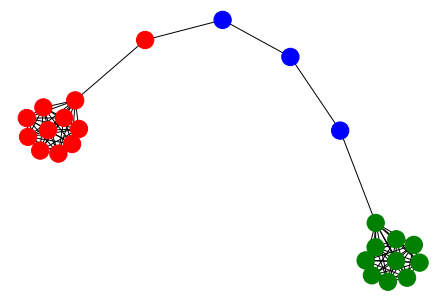

In [6]:
nx.draw_spring(G, node_color=[colors[label] for label in labels])

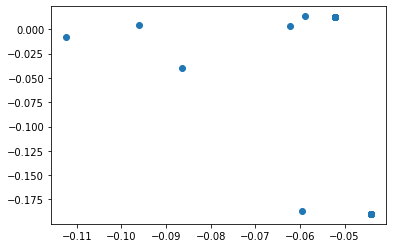

In [13]:
plt.scatter(np.array(embeddings[:, 0]), np.array(embeddings[:, 1]))

## Unsupervised GCN training using similarity graph distance

For the next example, we need to install StellarGraph, the python library we will be using to build the model

In [14]:
import pandas as pd
import numpy as np
import networkx as nx
import os

import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN

import tensorflow as tf
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In this demo, we will be using the PROTEINS dataset, already integrated in StellarGraph

In [15]:
dataset = sg.datasets.PROTEINS()
display(HTML(dataset.description))
graphs, graph_labels = dataset.load()

In [16]:
# let's print some info to better understand the dataset
print(graphs[0].info())
graph_labels.value_counts().to_frame()

StellarGraph: Undirected multigraph
 Nodes: 42, Edges: 162

 Node types:
  default: [42]
    Features: float32 vector, length 4
    Edge types: default-default->default

 Edge types:
    default-default->default: [162]
        Weights: all 1 (default)
        Features: none


,label
1,663
2,450


### Model definition
It's now time to build-up the model. StellarGraph offers several utility function to load and process the dataset, as well as define the GNN model and train.

In [17]:
# TODO
generator = sg.mapper.PaddedGraphGenerator(graphs)

In [18]:
# define a GCN model containing 2 layers of size 64 and 32, respectively. 
# ReLU activation function is used to add non-linearity between layers
gc_model = sg.layer.GCNSupervisedGraphClassification(
    [64, 32], ["relu", "relu"], generator, pool_all_layers=True
)

In [19]:
inp1, out1 = gc_model.in_out_tensors()
inp2, out2 = gc_model.in_out_tensors()

vec_distance = tf.norm(out1 - out2, axis=1)

In [20]:
pair_model = Model(inp1 + inp2, vec_distance)
embedding_model = Model(inp1, out1)

In [21]:
def graph_distance(graph1, graph2):
    spec1 = nx.laplacian_spectrum(graph1.to_networkx(feature_attr=None))
    spec2 = nx.laplacian_spectrum(graph2.to_networkx(feature_attr=None))
    k = min(len(spec1), len(spec2))
    return np.linalg.norm(spec1[:k] - spec2[:k])

In [22]:
graph_idx = np.random.RandomState(0).randint(len(graphs), size=(100, 2))
targets = [graph_distance(graphs[left], graphs[right]) for left, right in graph_idx]
train_gen = generator.flow(graph_idx, batch_size=10, targets=targets)

In [23]:
pair_model.compile(optimizers.Adam(1e-2), loss="mse")

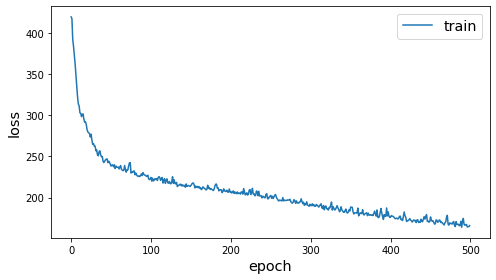

In [24]:
history = pair_model.fit(train_gen, epochs=500, verbose=0)
sg.utils.plot_history(history)

In [25]:
embeddings = embedding_model.predict(generator.flow(graphs))

In [26]:
from sklearn.manifold import TSNE

tsne = TSNE(2)
two_d = tsne.fit_transform(embeddings)

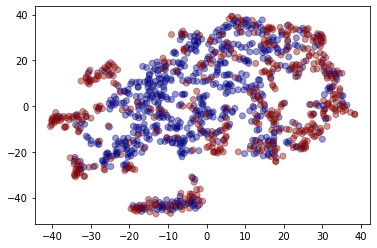

In [27]:
plt.scatter(two_d[:, 0], two_d[:, 1], c=graph_labels.cat.codes, cmap="jet", alpha=0.4)
plt.savefig('embedding_TSNE.png',dpi=300)